In [1]:
import sys
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Ferramentas de Pré-processamento e Modelagem
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE

# Métricas de Avaliação
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import joblib
import os

In [2]:
# --- Carregamento dos Dados Mestres ---
import pandas as pd
import sys

# Carrega a tabela de modelagem COMPLETA (com todos os anos)
path_final_table = '../data/processed/modeling_table_final.parquet' 
df_completo = pd.read_parquet(path_final_table)

print(f"Tabela de modelagem mestra carregada com {df_completo.shape[0]} dias e {df_completo.shape[1]} colunas.")
print(f"Período total dos dados: de {df_completo.index.min().date()} a {df_completo.index.max().date()}.")

Tabela de modelagem mestra carregada com 5693 dias e 29 colunas.
Período total dos dados: de 2010-02-10 a 2025-09-11.


In [3]:
# --- DEFINIÇÃO COMPLETA DOS GRUPOS DE FEATURES ---

features_carga = [
    'programada', 
    'verificada', 
    'diferenca_verif_prog'
]
features_geracao = [
    'geracao_total_diaria_go', 
    'geracao_fotovoltaica_diaria', 
    'geracao_hidroelétrica_diaria', 
    'geracao_térmica_diaria'
]
features_rede = [
    'total_mwh_restrito_go', 
    'saldo_intercambio_seco', 
    'restricao_razao_rel', 
    'restricao_razao_cnf', 
    'restricao_razao_ene', 
    'restricao_razao_par', 
    'restricao_origem_loc', 
    'restricao_origem_sis'
]
features_hidrica = [
    'ear_percentual_seco', 
    'ena_percentual_mlt_seco'
]
features_adicionais = [
    'cmo_semanal_seco', 
    'disponibilidade_total_diaria_go', 
    'indicador_ccal_mensal'
]
features_clima = [
    'ghi', 
    'temp2m_c', 
    'precipitacao_mm'
]
features_avancadas = [
    'carga_media_7d', 
    'carga_std_7d', 
    'geracao_media_7d', 
    'ear_ontem', 
    'ear_diff_3d', 
    'margem_oferta_demanda', 
    'pressao_demanda_ear', 
    'precip_acumulada_14d', 
    'precip_acumulada_30d'
]
features_calendario = [
    'mes' , 
    'dia_da_semana', 
    'dia_do_ano'
]

print("Grupos de features definidos com sucesso.")

Grupos de features definidos com sucesso.


In [4]:
# --- Célula 4 (Nova Versão): Painel de Controle do Experimento ---
import sys

# --- ADICIONADO: Importação das configurações (usado como fallback) ---
sys.path.append('..') 
from config import END_YEAR, END_MONTH # Usaremos o END_YEAR como limite superior
# ----------------------------------------------------------------------

# --- ESCOLHA O CENÁRIO PARA TESTAR ---
# Opções: 'pos_2022', 'pos_2020', 'pos_2017', 'pos_2015', 'pos_2013', 'pos_2010'
CENARIO_ESCOLHIDO = 'pos_2010' 
# -------------------------------------

# Define o período de análise e as features com base no cenário escolhido
if CENARIO_ESCOLHIDO == 'pos_2022':
    START_YEAR = 2022
    nome_cenario = "Modelo Pós-2022 (Features de Geração)"
    # Features mais ricas, incluindo geração detalhada. Exclui carga verificada.
    features_para_teste_nomes = (
        features_geracao + 
        features_rede + 
        features_hidrica +
        features_adicionais + 
        features_clima + 
        features_calendario +
        features_avancadas + 
        ['programada'] 
    )
elif CENARIO_ESCOLHIDO == 'pos_2020':
    START_YEAR = 2020
    nome_cenario = "Modelo Pós-2020 (Histórico com Carga Prog.)"
    # Período que já inclui 'carga_programada', mas não a geração detalhada.
    features_para_teste_nomes = (
        features_hidrica + 
        features_adicionais + 
        features_clima +
        features_calendario + 
        features_avancadas + 
        ['programada']
    )
elif CENARIO_ESCOLHIDO == 'pos_2017':
    START_YEAR = 2017
    nome_cenario = "Modelo Pós-2017 (Histórico Intermediário)"
    # Período sem dados de carga, mas já com disponibilidade de usinas.
    features_para_teste_nomes = (
        features_hidrica + 
        features_adicionais + 
        features_clima +
        features_calendario + 
        features_avancadas
    )
elif CENARIO_ESCOLHIDO == 'pos_2015':
    START_YEAR = 2015
    nome_cenario = "Modelo Pós-2015 (Histórico com Disponibilidade)"
    # Similar ao 2017, mas com mais 2 anos de dados.
    features_para_teste_nomes = (
        features_hidrica + 
        features_adicionais + 
        features_clima +
        features_calendario + 
        features_avancadas
    )
elif CENARIO_ESCOLHIDO == 'pos_2013':
    START_YEAR = 2013
    nome_cenario = "Modelo Pós-2013 (Histórico Extendido Básico)"
    # Período sem carga e sem disponibilidade total de usinas.
    features_para_teste_nomes = (
        features_hidrica + 
        features_clima + 
        features_calendario + 
        features_avancadas + 
        ['cmo_semanal_seco', 'indicador_ccal_mensal']
    )
elif CENARIO_ESCOLHIDO == 'pos_2010':
    START_YEAR = 2010
    nome_cenario = "Modelo Pós-2010 (Máximo Histórico Básico)"
    # Cenário mais longo, com features hídricas e de preço (CMO) como base.
    features_para_teste_nomes = (
        features_hidrica + 
        features_clima + 
        features_calendario + 
        features_avancadas + 
        ['cmo_semanal_seco', 'indicador_ccal_mensal']
    )
else:
    raise ValueError("Cenário escolhido é inválido.")

print(f"--- INICIANDO EXPERIMENTO COM O CENÁRIO: '{nome_cenario}' ---")
print(f"Período de análise: de {START_YEAR} a {END_YEAR}")

# --- FILTRAGEM E SELEÇÃO DE DADOS ---
# 1. Filtra a tabela mestra para o período do experimento
anos_de_interesse = range(START_YEAR, END_YEAR + 1)
df = df_completo[df_completo.index.year.isin(anos_de_interesse)].copy()
print(f"-> Tabela filtrada por data, resultando em {df.shape[0]} dias para modelagem.")

# 2. Seleciona apenas as colunas válidas para o cenário (e que existem no dataframe)
# Isso remove automaticamente features avançadas que dependem de colunas ausentes.
features_para_teste = [col for col in features_para_teste_nomes if col in df.columns]
X = df[features_para_teste]
y = df['nivel_risco']

print(f"Número de features selecionadas para este cenário: {len(X.columns)}")
print("\nAmostragem de classes no dataset deste cenário:")
print(y.value_counts())

--- INICIANDO EXPERIMENTO COM O CENÁRIO: 'Modelo Pós-2010 (Máximo Histórico Básico)' ---
Período de análise: de 2010 a 2025
-> Tabela filtrada por data, resultando em 5693 dias para modelagem.
Número de features selecionadas para este cenário: 15

Amostragem de classes no dataset deste cenário:
nivel_risco
baixo    5328
alto      183
medio     182
Name: count, dtype: int64


In [5]:
# --- PREPARAÇÃO DOS DADOS PARA MODELAGEM ---

mapeamento_risco = {'baixo': 0, 'medio': 1, 'alto': 2}
y_encoded = y.map(mapeamento_risco)
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded
)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\n--- Aplicando SMOTE nos dados de treino ---")
min_class_count = y_train.value_counts().min()
if min_class_count > 1:
    k_neighbors_smote = min(5, min_class_count - 1)
    smote = SMOTE(random_state=42, k_neighbors=k_neighbors_smote)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)
else:
    print("AVISO: A menor classe tem apenas 1 membro no treino. Pulando o SMOTE.")
    X_train_resampled, y_train_resampled = X_train_scaled, y_train

print("\nPreparação dos dados concluída.")


--- Aplicando SMOTE nos dados de treino ---

Preparação dos dados concluída.


In [6]:
# --- Célula 6: Busca de Hiperparâmetros (VERSÃO COMPLETA PARA XGBOOST) ---

# Grade de parâmetros expandida para o XGBoost
param_grid = {
    'n_estimators': [800, 1000, 1500],
    'max_depth': [5, 7, 9],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.8, 0.9],         # Adicionado: % de amostras por árvore
    'colsample_bytree': [0.7, 0.8, 0.9],  # Adicionado: % de features por árvore
    'gamma': [0, 0.1, 0.2],               # Adicionado: Mínima redução de perda para split
    'reg_alpha': [0, 0.1, 0.5],           # Adicionado: Regularização L1
    'reg_lambda': [1, 1.5, 2]             # Adicionado: Regularização L2
}

# Instancia o classificador XGBoost
# O eval_metric='mlogloss' é importante para problemas multiclasse
xgb = XGBClassifier(objective='multi:softmax', num_class=3, random_state=42, eval_metric='mlogloss')

# Configura a busca aleatória de hiperparâmetros
random_search = RandomizedSearchCV(
    estimator=xgb, 
    param_distributions=param_grid, 
    n_iter=20,  # Aumentar este valor (ex: 30 ou 50) resulta em uma busca mais longa, porém mais exaustiva
    cv=4, 
    scoring='recall_weighted', 
    n_jobs=-1, 
    random_state=42, 
    verbose=1
) 

print("\nIniciando a busca de hiperparâmetros para o XGBoost...")

# Converte o array NumPy do SMOTE de volta para um DataFrame para evitar warnings
X_train_resampled_df = pd.DataFrame(X_train_resampled, columns=X_train.columns)

# A busca é feita nos dados já balanceados
random_search.fit(X_train_resampled_df, y_train_resampled)

print("Busca de hiperparâmetros concluída.")

best_model = random_search.best_estimator_
print("\nMelhores parâmetros encontrados:", random_search.best_params_)


Iniciando a busca de hiperparâmetros para o XGBoost...
Fitting 4 folds for each of 20 candidates, totalling 80 fits
Busca de hiperparâmetros concluída.

Melhores parâmetros encontrados: {'subsample': 0.8, 'reg_lambda': 2, 'reg_alpha': 0, 'n_estimators': 1500, 'max_depth': 9, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.7}



Obtendo as probabilidades do melhor modelo XGBoost...

--- Resultados Finais do Cenário: Modelo Pós-2010 (Máximo Histórico Básico) (XGBoost) ---
              precision    recall  f1-score   support

       baixo       0.95      0.86      0.90      1598
       medio       0.09      0.13      0.10        55
        alto       0.04      0.13      0.06        55

    accuracy                           0.81      1708
   macro avg       0.36      0.37      0.36      1708
weighted avg       0.89      0.81      0.85      1708



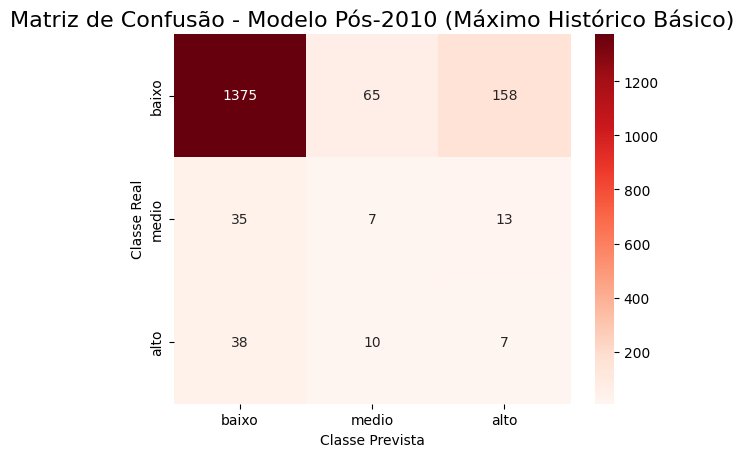

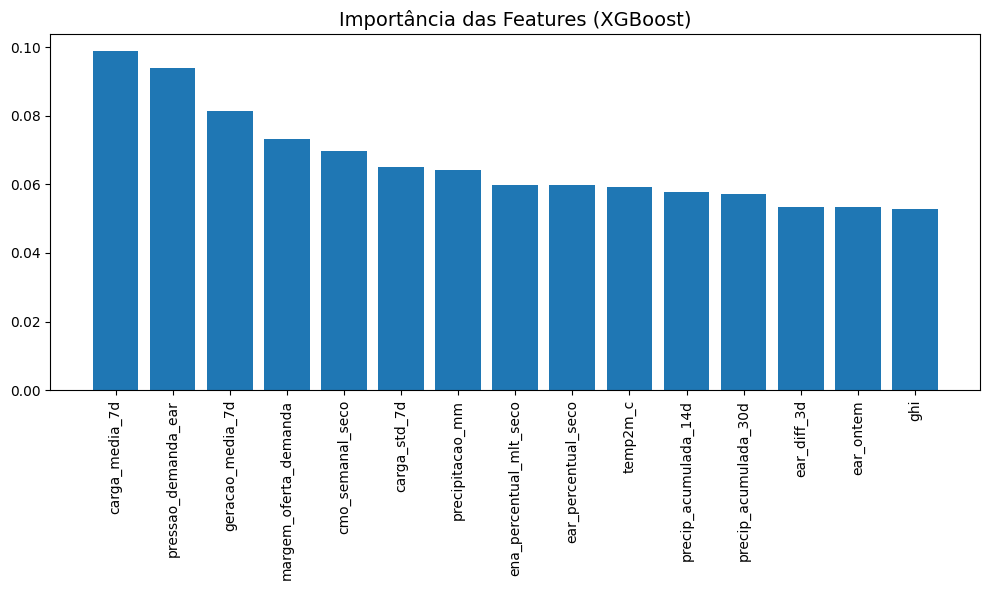


Modelo XGBoost salvo em: ../models/best_xgboost_model_2010.joblib
Scaler salvo em: ../models/scaler_xgb_2010.joblib


In [7]:
# --- Célula 7: Avaliação Final e Salvamento do Modelo (XGBoost) ---


# 1. Avaliação com Ajuste de Limiar
print("\nObtendo as probabilidades do melhor modelo XGBoost...")
y_pred_proba = best_model.predict_proba(X_test_scaled)

# Ajuste de limiares
threshold_alto = 0.10
threshold_medio = 0.20

y_pred_custom = []
for probs in y_pred_proba:
    prob_baixo, prob_medio, prob_alto = probs
    if prob_alto >= threshold_alto:
        y_pred_custom.append(2)
    elif prob_medio >= threshold_medio:
        y_pred_custom.append(1)
    else:
        y_pred_custom.append(0)

y_pred_custom = np.array(y_pred_custom)

print(f"\n--- Resultados Finais do Cenário: {nome_cenario} (XGBoost) ---")
print(classification_report(
    y_test, y_pred_custom, 
    target_names=mapeamento_risco.keys(), 
    zero_division=0
))

cm_custom = confusion_matrix(y_test, y_pred_custom)
sns.heatmap(
    cm_custom, annot=True, fmt='d', cmap='Reds',
    xticklabels=mapeamento_risco.keys(),
    yticklabels=mapeamento_risco.keys()
)
plt.title(f'Matriz de Confusão - {nome_cenario}', fontsize=16)
plt.ylabel('Classe Real')
plt.xlabel('Classe Prevista')
plt.show()

# 2. Análise de Importância das Features
importances = best_model.feature_importances_
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(10,6))
plt.title("Importância das Features (XGBoost)", fontsize=14)
plt.bar(range(len(importances)), importances[indices], align="center")
plt.xticks(range(len(importances)), [X_train.columns[i] for i in indices], rotation=90)
plt.tight_layout()
plt.show()

# --- CORREÇÃO ABAIXO ---

# 3. Salvamento do Modelo e do Scaler com Nomes Dinâmicos
output_dir = "../models"
os.makedirs(output_dir, exist_ok=True)

# Extrai o ano do cenário para criar nomes de arquivo dinâmicos
# Ex: 'pos_2020' -> '2020'
year_str = CENARIO_ESCOLHIDO.split('_')[1]

# Define os caminhos dos arquivos dinamicamente
model_path = os.path.join(output_dir, f"best_xgboost_model_{year_str}.joblib")
scaler_path = os.path.join(output_dir, f"scaler_xgb_{year_str}.joblib")

# Salva o modelo treinado
joblib.dump(best_model, model_path)

# Salva também o scaler
joblib.dump(scaler, scaler_path)

# Imprime as mensagens com os nomes dinâmicos
print(f"\nModelo XGBoost salvo em: {model_path}")
print(f"Scaler salvo em: {scaler_path}")